# Modelo de Clasificación

In [1]:
import sys, os
sys.path.append(os.getcwd().replace('/notebooks',''))  # Replace with current directory name

In [2]:
#===== Configuración regional =================================
import locale

# Name might vary with operating system.
locale.setlocale(locale.LC_ALL, 'es_ES')

locale._override_localeconv["thousands_sep"] = "."

#===== Librerías ==============================================
# Importing the Warnings library for better presentation
import warnings

# Importando la biblioteca pandas para manipulación y análisis de datos
import pandas as pd
# Importando NumPy para operaciones numéricas y manipulación de arreglos
import numpy as np
# Importando itertools para generar combinaciones de columnas
import itertools

# Importando matplotlib.pyplot para crear gráficos y visualizaciones
import matplotlib.pyplot as plt
# Importando Seaborn para visualización de datos estadísticos (opcional, pero puede complementar a Plotly)
import seaborn as sns
# Importando Plotly Express para visualizaciones interactivas de alto nivel y fáciles de usar
import plotly.express as px
# Importando Plotly Graph Objects para un control más detallado sobre las visualizaciones
import plotly.graph_objects as go
# Multiple graphs in a figure
from plotly.subplots import make_subplots

# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

#===== Ajustes visualización gráficos ============================
warnings.filterwarnings('ignore', category=DeprecationWarning)
# Matplotlib inline to visualize Matplotlib graphs
%matplotlib inline

# Configuration to set so that all the Seaborn figures come out with this size
%config Inlinebackend.figure_format= 'retina'
warnings.resetwarnings()

# Set the Seaborn context to "poster" for larger text and figures
sns.set_context("poster")

# Set the default figure size for Seaborn plots
sns.set(rc={"figure.figsize": (12., 6.)})

# Set the Seaborn style to "whitegrid" for a white background with gridlines
sns.set_style("whitegrid")

#===== Librerías proyecto ============================
from utils.data import Datasets
from utils.eda import column_explore

#===== Librerías regresión ============================
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import root_mean_squared_error # ?????

from sklearn import metrics

In [3]:
ds = Datasets()
cash, fees = ds.get_datasets()
cash = ds.desglose_created_at(cash)
cash.rename(columns={'id': 'cash_request_id'}, inplace=True)
print(cash.columns)
print()
print(fees.columns)

Index(['cash_request_id', 'amount', 'status', 'created_at', 'updated_at',
       'user_id', 'moderated_at', 'deleted_account_id', 'reimbursement_date',
       'cash_request_received_date', 'money_back_date', 'transfer_type',
       'send_at', 'recovery_status', 'reco_creation', 'reco_last_update',
       'id_usuario', 'created_year', 'created_month', 'created_year_month',
       'created_dayofweek', 'created_hour'],
      dtype='object')

Index(['id', 'cash_request_id', 'type', 'status', 'category', 'total_amount',
       'reason', 'created_at', 'updated_at', 'paid_at', 'from_date', 'to_date',
       'charge_moment'],
      dtype='object')


In [4]:
cash = ds.create_cash_cohorts(cash)
print(cash.columns)

Index(['cash_request_id', 'amount', 'status', 'created_at', 'updated_at',
       'user_id', 'moderated_at', 'deleted_account_id', 'reimbursement_date',
       'cash_request_received_date', 'money_back_date', 'transfer_type',
       'send_at', 'recovery_status', 'reco_creation', 'reco_last_update',
       'id_usuario', 'created_year', 'created_month', 'created_year_month',
       'created_dayofweek', 'created_hour', 'cohorte', 'cohorte_lbl'],
      dtype='object')


In [5]:
# Tratamiento de Valores Faltantes
# La columna `category` tiene muy pocos valores: sólo está poblada cuando ha habido algún tipo de incidente (`fees['type']=='incident'`). Veremos cómo podemos poblar los valores faltantes para poder incluir este dato en nuestro análisis de regresión.
# fees[fees['category'].isna()].sample(20)
# fees['category'].fillna('ninguna', inplace=True)
fees['category'] = fees.apply(lambda row: row.category if row.category in ['rejected_direct_debit','month_delay_on_payment'] else row.type, axis=1)
print(fees.category.value_counts().sum())
fees.category.value_counts()


21061


category
instant_payment           11099
postpone                   7766
rejected_direct_debit      1599
month_delay_on_payment      597
Name: count, dtype: int64

In [6]:
# Selección de Características para la Regresión
# ['cash_request_id', 'amount', 'status', 'created_at', 'updated_at',
#        'user_id', 'moderated_at', 'deleted_account_id', 'reimbursement_date',
#        'cash_request_received_date', 'money_back_date', 'transfer_type',
#        'send_at', 'recovery_status', 'reco_creation', 'reco_last_update',
#        'id_usuario', 'created_year', 'created_month', 'created_year_month',
#        'created_dayofweek', 'created_hour', 'cohorte', 'cohorte_lbl']
subset_cash=['cash_request_id','amount','status','moderated_at','transfer_type','recovery_status','user_id','deleted_account_id','id_usuario','created_year_month','created_at','created_dayofweek','created_hour','cohorte_lbl']
cash_ss = cash[subset_cash]
cash_ss

,cash_request_id,amount,status,moderated_at,transfer_type,recovery_status,user_id,deleted_account_id,id_usuario,created_year_month,created_at,created_dayofweek,created_hour,cohorte_lbl
0,5,100.0,rejected,2019-12-11 16:47:42.405646+00:00,regular,NaN,804.0,NaN,804,2019-12,2019-12-10 19:05:21.596873+00:00,2,19,COH-02.dic/19
1,70,100.0,rejected,2019-12-11 14:24:22.897988+00:00,regular,NaN,231.0,NaN,231,2019-12,2019-12-10 19:50:12.347780+00:00,2,19,COH-02.dic/19
2,7,100.0,rejected,2019-12-11 09:46:59.777728+00:00,regular,NaN,191.0,NaN,191,2019-12,2019-12-10 19:13:35.825460+00:00,2,19,COH-02.dic/19
3,10,99.0,rejected,2019-12-18 14:26:18.128407+00:00,regular,NaN,761.0,NaN,761,2019-12,2019-12-10 19:16:10.880172+00:00,2,19,COH-02.dic/19
4,1594,100.0,rejected,2020-05-07 09:21:55.320193+00:00,regular,NaN,7686.0,NaN,7686,2020-5,2020-05-06 09:59:38.877376+00:00,3,9,COH-07.may/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23965,20616,100.0,money_back,NaT,instant,NaN,13681.0,NaN,13681,2020-10,2020-10-12 13:54:11.686225+00:00,1,13,COH-08.jun/20
23966,25243,50.0,money_back,NaT,instant,completed,NaN,30367.0,30367,2020-10,2020-10-27 14:41:25.734910+00:00,2,14,COH-12.oct/20
23967,22357,100.0,money_back,NaT,instant,NaN,82122.0,NaN,82122,2020-10,2020-10-20 07:58:04.006937+00:00,2,7,COH-12.oct/20
23968,20256,100.0,money_back,NaT,instant,NaN,64517.0,NaN,64517,2020-10,2020-10-10 05:40:55.700422+00:00,6,5,COH-12.oct/20


In [7]:
subset_fees=['id','cash_request_id','type', 'status', 'category', 'total_amount','charge_moment']
fees_ss = fees[subset_fees]
fees_ss

,id,cash_request_id,type,status,category,total_amount,charge_moment
0,6537,14941,instant_payment,rejected,instant_payment,5.0,after
1,6961,11714,incident,accepted,rejected_direct_debit,5.0,after
2,16296,23371,instant_payment,accepted,instant_payment,5.0,after
3,20775,26772,instant_payment,accepted,instant_payment,5.0,after
4,11242,19350,instant_payment,accepted,instant_payment,5.0,after
...,...,...,...,...,...,...,...
21056,12372,20262,instant_payment,rejected,instant_payment,5.0,after
21057,20768,26764,instant_payment,rejected,instant_payment,5.0,after
21058,18779,25331,instant_payment,rejected,instant_payment,5.0,after
21059,16542,23628,instant_payment,rejected,instant_payment,5.0,after


In [8]:
# Dataset Unificado para la Regresión
# merged = pd.merge(cash_ss, fees_ss.add_prefix('fee_'), left_on='cash_request_id', right_on='fee_cash_request_id', how='outer') # 32098 rows
merged = pd.merge(cash_ss, fees_ss.add_prefix('fee_'), left_on='cash_request_id', right_on='fee_cash_request_id', how='left') # 32098 rows
print(merged.shape)

# metricas_usuario[metricas_usuario['deleted_account_id'].isna()] # 1309
merged[merged['user_id'].isna()]
merged['user_id'].fillna(0)
merged['existing_account'] = merged['user_id'].transform(lambda x: 1 if x > 0 else 0)
# merged['existing_account'].value_counts()

(32094, 21)


In [9]:
merged = merged[~merged['fee_status'].isin(['cancelled','rejected'])]
print(merged.shape)

(25966, 22)


In [10]:
merged['recovery_status'] = merged['recovery_status'].fillna('unknown')
merged['was_moderated'] = merged['moderated_at'].apply(lambda x: 1 if x else 0)

In [11]:
top1000 = merged[merged['status']=='money_back'].groupby('id_usuario').agg(
    amount_fees=('fee_total_amount','sum'))
top1000_usrs = top1000.sort_values(by='amount_fees', ascending=False).iloc[:1000].index
# top1000_usrs

top_users = merged[merged['id_usuario'].isin(top1000_usrs)].reset_index()
# top_users.info()

top_users.drop(columns=['recovery_status','deleted_account_id'], inplace=True)
top_users.drop(columns=['user_id'], inplace=True)

top_users.drop(columns=['fee_charge_moment'], inplace=True)
top_users.drop(columns=['status'], inplace=True)

top_users.dropna(inplace=True, ignore_index=True)

# # Dropping rows based on index
# # Drop de las filas 12 filas de cash_request creados el 2020-11
# cr_november = top_users[top_users['created_year_month']=='2020-11']
# cr_november
# cr_november.index #Index([1911, 1960, 4605, 11870], dtype='int64')
# top_users.drop(index=cr_november.index, inplace=True)  

In [12]:
top_users.drop(columns=['index'], inplace=True)

In [13]:
top_users

,cash_request_id,amount,moderated_at,transfer_type,id_usuario,created_year_month,created_at,created_dayofweek,created_hour,cohorte_lbl,fee_id,fee_cash_request_id,fee_type,fee_status,fee_category,fee_total_amount,existing_account,was_moderated
0,2203,100.0,2020-05-27 10:02:13.094467+00:00,regular,2109,2020-5,2020-05-27 02:26:27.615190+00:00,3,2,COH-02.dic/19,100.0,2203.0,postpone,accepted,postpone,5.0,1,1
1,2135,100.0,2020-05-23 11:22:27.850411+00:00,regular,9475,2020-5,2020-05-23 11:18:15.829401+00:00,6,11,COH-07.may/20,65.0,2135.0,postpone,accepted,postpone,5.0,1,1
2,2328,100.0,2020-05-30 13:42:38.937708+00:00,regular,4982,2020-5,2020-05-29 20:32:18.312805+00:00,5,20,COH-06.abr/20,54.0,2328.0,postpone,accepted,postpone,5.0,1,1
3,2328,100.0,2020-05-30 13:42:38.937708+00:00,regular,4982,2020-5,2020-05-29 20:32:18.312805+00:00,5,20,COH-06.abr/20,1285.0,2328.0,postpone,accepted,postpone,5.0,1,1
4,1749,100.0,2020-05-14 09:11:26.834746+00:00,regular,1658,2020-5,2020-05-13 23:04:24.792774+00:00,3,23,COH-02.dic/19,76.0,1749.0,postpone,accepted,postpone,5.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812,19329,100.0,2020-10-06 08:07:25.588896+00:00,instant,20237,2020-10,2020-10-05 19:38:30.924473+00:00,1,19,COH-08.jun/20,11232.0,19329.0,instant_payment,accepted,instant_payment,5.0,1,1
2813,19343,50.0,2020-10-06 08:18:59.183420+00:00,instant,18390,2020-10,2020-10-05 22:17:49.134327+00:00,1,22,COH-08.jun/20,14463.0,19343.0,postpone,accepted,postpone,5.0,1,1
2814,19343,50.0,2020-10-06 08:18:59.183420+00:00,instant,18390,2020-10,2020-10-05 22:17:49.134327+00:00,1,22,COH-08.jun/20,11240.0,19343.0,instant_payment,accepted,instant_payment,5.0,1,1
2815,20216,100.0,2020-10-10 11:27:06.421615+00:00,instant,20459,2020-10,2020-10-09 19:54:04.768124+00:00,5,19,COH-08.jun/20,19696.0,20216.0,postpone,accepted,postpone,5.0,1,1


In [14]:
top_usuarios = top_users['id_usuario'].to_list()
print(top_usuarios)

[2109, 9475, 4982, 4982, 1658, 1658, 6536, 6536, 6536, 29041, 29041, 29041, 29041, 47, 47, 2900, 2900, 9422, 231, 6590, 6974, 9259, 10174, 952, 964, 964, 964, 9199, 9199, 9199, 9199, 872, 872, 10525, 10525, 10525, 11722, 19737, 10142, 10282, 9297, 9297, 9297, 4317, 2305, 138, 7445, 18352, 18352, 11318, 2602, 16360, 16360, 47, 16459, 16459, 20842, 16356, 3162, 33465, 33465, 30337, 30337, 30337, 30337, 30337, 138, 138, 11977, 11977, 11977, 8944, 8944, 12274, 12274, 2460, 2460, 18326, 18326, 18326, 11544, 11544, 11544, 13255, 13255, 13255, 11110, 11110, 10166, 10166, 17418, 11041, 11041, 11678, 11678, 11678, 11289, 16168, 16168, 9199, 9199, 9199, 8582, 8582, 213, 213, 213, 213, 213, 213, 15228, 15228, 34350, 26058, 22531, 22531, 4904, 4904, 9826, 11998, 13758, 13758, 13758, 12077, 12077, 14334, 35354, 35354, 11862, 11862, 13070, 13070, 11181, 11181, 13929, 13929, 13929, 17850, 17850, 26585, 3309, 3309, 18119, 18119, 7192, 7192, 35634, 26125, 26125, 526, 10339, 6608, 6608, 6608, 2152, 1850

In [15]:
merged['top_user'] = merged['id_usuario'].apply(lambda x: 1 if x in top_usuarios else 0)
merged

,cash_request_id,amount,status,moderated_at,transfer_type,recovery_status,user_id,deleted_account_id,id_usuario,created_year_month,...,fee_id,fee_cash_request_id,fee_type,fee_status,fee_category,fee_total_amount,fee_charge_moment,existing_account,was_moderated,top_user
0,5,100.0,rejected,2019-12-11 16:47:42.405646+00:00,regular,unknown,804.0,NaN,804,2019-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0
1,70,100.0,rejected,2019-12-11 14:24:22.897988+00:00,regular,unknown,231.0,NaN,231,2019-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1
2,7,100.0,rejected,2019-12-11 09:46:59.777728+00:00,regular,unknown,191.0,NaN,191,2019-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0
3,10,99.0,rejected,2019-12-18 14:26:18.128407+00:00,regular,unknown,761.0,NaN,761,2019-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0
4,1594,100.0,rejected,2020-05-07 09:21:55.320193+00:00,regular,unknown,7686.0,NaN,7686,2020-5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32089,22357,100.0,money_back,NaT,instant,unknown,82122.0,NaN,82122,2020-10,...,15041.0,22357.0,instant_payment,accepted,instant_payment,5.0,after,1,1,0
32090,20256,100.0,money_back,NaT,instant,unknown,64517.0,NaN,64517,2020-10,...,20325.0,20256.0,postpone,accepted,postpone,5.0,before,1,1,0
32091,20256,100.0,money_back,NaT,instant,unknown,64517.0,NaN,64517,2020-10,...,12366.0,20256.0,instant_payment,accepted,instant_payment,5.0,after,1,1,0
32092,19886,100.0,direct_debit_sent,NaT,instant,unknown,44867.0,NaN,44867,2020-10,...,12513.0,19886.0,postpone,accepted,postpone,5.0,before,1,1,0


In [16]:
merged.drop(columns=['cash_request_id'], inplace=True)
merged.drop(columns=['user_id'], inplace=True)
merged.drop(columns=['deleted_account_id'], inplace=True)
merged.drop(columns=['id_usuario'], inplace=True)
merged.drop(columns=['moderated_at'], inplace=True)
merged.drop(columns=['created_at'], inplace=True)
merged.drop(columns=['fee_id'], inplace=True)
merged.drop(columns=['fee_cash_request_id'], inplace=True)
merged.dropna(inplace=True)

In [17]:
merged

,amount,status,transfer_type,recovery_status,created_year_month,created_dayofweek,created_hour,cohorte_lbl,fee_type,fee_status,fee_category,fee_total_amount,fee_charge_moment,existing_account,was_moderated,top_user
48,25.0,money_back,instant,unknown,2020-10,5,15,COH-11.sep/20,instant_payment,accepted,instant_payment,5.0,after,1,1,0
88,100.0,money_back,regular,unknown,2020-5,3,2,COH-02.dic/19,postpone,accepted,postpone,5.0,before,1,1,1
170,50.0,money_back,instant,unknown,2020-10,1,16,COH-09.jul/20,postpone,accepted,postpone,5.0,before,0,1,1
171,50.0,money_back,instant,unknown,2020-10,1,16,COH-09.jul/20,instant_payment,accepted,instant_payment,5.0,after,0,1,1
233,100.0,money_back,regular,unknown,2020-5,3,10,COH-04.feb/20,postpone,accepted,postpone,5.0,before,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32089,100.0,money_back,instant,unknown,2020-10,2,7,COH-12.oct/20,instant_payment,accepted,instant_payment,5.0,after,1,1,0
32090,100.0,money_back,instant,unknown,2020-10,6,5,COH-12.oct/20,postpone,accepted,postpone,5.0,before,1,1,0
32091,100.0,money_back,instant,unknown,2020-10,6,5,COH-12.oct/20,instant_payment,accepted,instant_payment,5.0,after,1,1,0
32092,100.0,direct_debit_sent,instant,unknown,2020-10,4,14,COH-11.sep/20,postpone,accepted,postpone,5.0,before,1,1,0


In [18]:
df = merged
df

,amount,status,transfer_type,recovery_status,created_year_month,created_dayofweek,created_hour,cohorte_lbl,fee_type,fee_status,fee_category,fee_total_amount,fee_charge_moment,existing_account,was_moderated,top_user
48,25.0,money_back,instant,unknown,2020-10,5,15,COH-11.sep/20,instant_payment,accepted,instant_payment,5.0,after,1,1,0
88,100.0,money_back,regular,unknown,2020-5,3,2,COH-02.dic/19,postpone,accepted,postpone,5.0,before,1,1,1
170,50.0,money_back,instant,unknown,2020-10,1,16,COH-09.jul/20,postpone,accepted,postpone,5.0,before,0,1,1
171,50.0,money_back,instant,unknown,2020-10,1,16,COH-09.jul/20,instant_payment,accepted,instant_payment,5.0,after,0,1,1
233,100.0,money_back,regular,unknown,2020-5,3,10,COH-04.feb/20,postpone,accepted,postpone,5.0,before,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32089,100.0,money_back,instant,unknown,2020-10,2,7,COH-12.oct/20,instant_payment,accepted,instant_payment,5.0,after,1,1,0
32090,100.0,money_back,instant,unknown,2020-10,6,5,COH-12.oct/20,postpone,accepted,postpone,5.0,before,1,1,0
32091,100.0,money_back,instant,unknown,2020-10,6,5,COH-12.oct/20,instant_payment,accepted,instant_payment,5.0,after,1,1,0
32092,100.0,direct_debit_sent,instant,unknown,2020-10,4,14,COH-11.sep/20,postpone,accepted,postpone,5.0,before,1,1,0


In [19]:
df.columns

Index(['amount', 'status', 'transfer_type', 'recovery_status',
       'created_year_month', 'created_dayofweek', 'created_hour',
       'cohorte_lbl', 'fee_type', 'fee_status', 'fee_category',
       'fee_total_amount', 'fee_charge_moment', 'existing_account',
       'was_moderated', 'top_user'],
      dtype='object')

In [20]:
df = ds.get_dummies_and_drop_cols(df, '', 'status')
df = ds.get_dummies_and_drop_cols(df, '', 'transfer_type')
df = ds.get_dummies_and_drop_cols(df, '', 'recovery_status')
# df = ds.get_dummies_and_drop_cols(df, '', 'created_year_month')
df = ds.get_dummies_and_drop_cols(df, '', 'cohorte_lbl')
df = ds.get_dummies_and_drop_cols(df, '', 'fee_type')
df = ds.get_dummies_and_drop_cols(df, '', 'fee_status')
df = ds.get_dummies_and_drop_cols(df, '', 'fee_category')
df = ds.get_dummies_and_drop_cols(df, '', 'fee_charge_moment')

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['created_year_month_dummy'] = labelencoder.fit_transform(df['created_year_month']) 
df.drop(columns=['created_year_month'], inplace=True)
df

,amount,created_dayofweek,created_hour,fee_total_amount,existing_account,was_moderated,top_user,status_canceled,status_direct_debit_rejected,status_direct_debit_sent,...,cohorte_lbl_COH-12.oct/20,cohorte_lbl_COH-13.nov/20,fee_type_instant_payment,fee_type_postpone,fee_status_confirmed,fee_category_month_delay_on_payment,fee_category_postpone,fee_category_rejected_direct_debit,fee_charge_moment_before,created_year_month_dummy
48,25.0,5,15,5.0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
88,100.0,3,2,5.0,1,1,1,0,0,0,...,0,0,0,1,0,0,1,0,1,2
170,50.0,1,16,5.0,0,1,1,0,0,0,...,0,0,0,1,0,0,1,0,1,0
171,50.0,1,16,5.0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
233,100.0,3,10,5.0,1,1,0,0,0,0,...,0,0,0,1,0,0,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32089,100.0,2,7,5.0,1,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
32090,100.0,6,5,5.0,1,1,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
32091,100.0,6,5,5.0,1,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
32092,100.0,4,14,5.0,1,1,0,0,0,1,...,0,0,0,1,0,0,1,0,1,0


## Definición de Características y Etiqueta

In [21]:
X = df.drop(columns='top_user')
y = df['top_user']

## Entrenamiento del Modelo

In [22]:
seed = 0
test_size = 0.3

n_neighbors = 10

#Train a classifier using .fit()
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [23]:
# predicted model
y_train_pred=knn.predict(X_train)

## Evaluación del Modelo

In [24]:
knn.score(X_train,y_train)

0.8149282296650717

### Rendimiento de Entrenamiento

(10451, 35) (4478, 35) (10451,) (4478,)

TRAINING STATS:
Classification accuracy: 0.8173380537747584


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


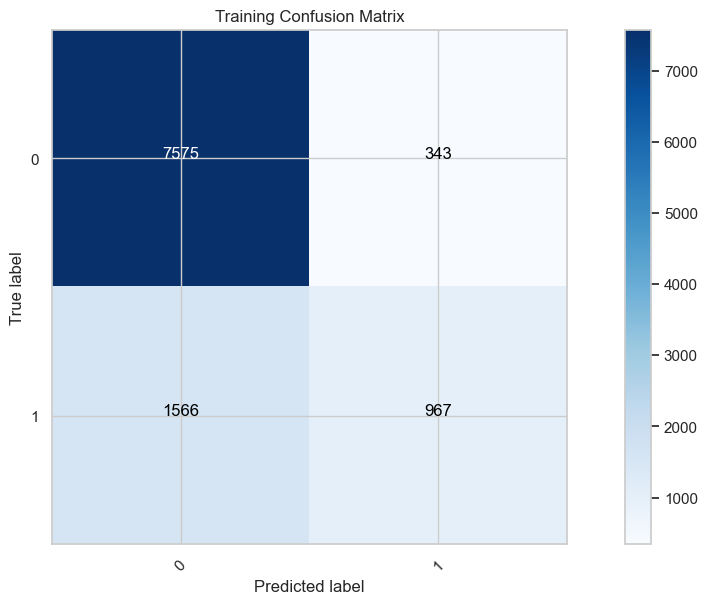

In [25]:
# Randomly permute a sequence of indices based on the size of y
perm = np.random.permutation(y.size)

# Define the proportion of the dataset to allocate for training
PRC = 0.7
# Calculate the split point for dividing the dataset
split_point = int(np.ceil(y.shape[0] * PRC))

# Split the dataset into training and testing sets based on the calculated split point
X_train = X.iloc[perm[:split_point]]
y_train = y.iloc[perm[:split_point]]

X_test = X.iloc[perm[split_point:]]
y_test = y.iloc[perm[split_point:]]

# Output the shapes of the training and testing datasets for verification
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Initialize the classifier with 1 neighbor for simplicity
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Predict the labels for the training set and evaluate performance
yhat = knn.predict(X_train)

# Print training statistics
print("\nTRAINING STATS:")
print("Classification accuracy:", metrics.accuracy_score(yhat, y_train))

# Visualize the confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_train)))
    plt.xticks(tick_marks, np.unique(y_train), rotation=45)
    plt.yticks(tick_marks, np.unique(y_train))

    # Loop over data dimensions and create text annotations.
    fmt = 'd'  # Format as decimal integer
    thresh = cm.max() / 2.  # Threshold for text color based on background
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Generate the confusion matrix from the training data predictions
cm = metrics.confusion_matrix(y_train, yhat)
# Call the function to plot the improved confusion matrix
plot_confusion_matrix(cm, "Training Confusion Matrix")

### Rendimiento de Prueba

TESTING STATS:
Classification accuracy: 0.7827154979901741


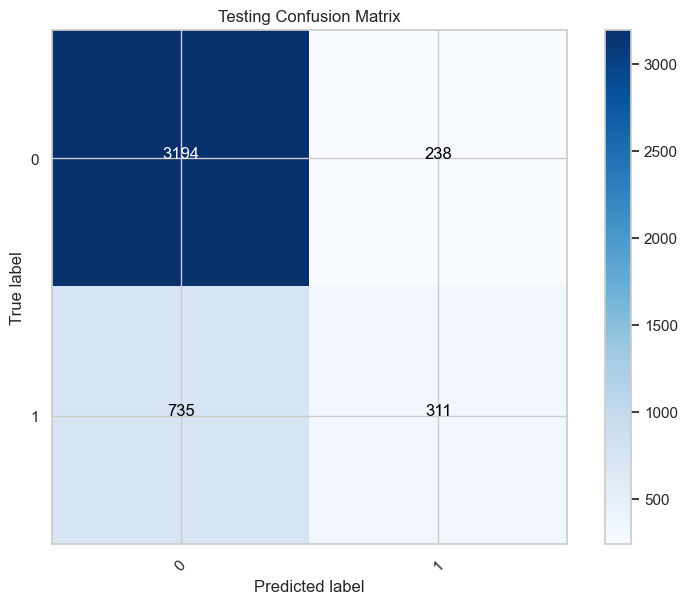

In [26]:
# Predict the labels for the test set to evaluate performance
yhat = knn.predict(X_test)

# Print testing statistics
print("TESTING STATS:")
print("Classification accuracy:", metrics.accuracy_score(yhat, y_test))

# Function to plot confusion matrix with annotations for clarity
def plot_confusion_matrix_with_numbers(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix with the actual counts displayed on the matrix for better clarity.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test), rotation=45)
    plt.yticks(tick_marks, np.unique(y_test))

    # Loop over data dimensions and create text annotations.
    fmt = 'd'  # Format as decimal integer
    thresh = cm.max() / 2.  # Threshold for text color based on background
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Generate the confusion matrix from the test data predictions
cm_test = metrics.confusion_matrix(y_test, yhat)

# Plot the improved confusion matrix with numbers for the test data
plot_confusion_matrix_with_numbers(cm_test, "Testing Confusion Matrix")

plt.show()

## Validación Cruzada

In [27]:
acc=np.zeros((10,))
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train,y_train)
    yhat=knn.predict(X_test)
    acc[i] = metrics.accuracy_score(yhat, y_test)
acc.shape=(1,10)
print ("Accuracy scores: ", acc)
print()
print ("Mean accuracy: "+str(np.mean(acc[0])))


Accuracy scores:  [[0.78142443 0.77673588 0.77137754 0.79236437 0.77651261 0.77829873
  0.78276401 0.78209422 0.77673588 0.78499665]]

Mean accuracy: 0.7803304308997545


In [28]:
# # Import necessary libraries from sklearn for model selection, classifiers, and metrics
# from sklearn import neighbors
# from sklearn import tree
# from sklearn import svm

# # Set the proportion of the dataset to be used for testing
# # PRC = 0.1

# # Initialize an array to store the accuracy results for each classifier across iterations
# acc_r = np.zeros((10,4))

# # Repeat the experiment 10 times to get a distribution of performance metrics
# for i in range(10):
#     # Split the dataset into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
#     # Initialize classifiers with specific configurations
#     nn1 = neighbors.KNeighborsClassifier(n_neighbors=1)  # 1-Nearest Neighbor classifier
#     nn3 = neighbors.KNeighborsClassifier(n_neighbors=3)  # 3-Nearest Neighbors classifier
#     svc = svm.SVC()  # Support Vector Machine classifier
#     dt = tree.DecisionTreeClassifier()  # Decision Tree classifier
    
#     # Train each classifier on the training set
#     nn1.fit(X_train, y_train)
#     nn3.fit(X_train, y_train)
#     svc.fit(X_train, y_train)
#     dt.fit(X_train, y_train)
    
#     # Predict the labels for the test set using each trained classifier
#     yhat_nn1 = nn1.predict(X_test)
#     yhat_nn3 = nn3.predict(X_test)
#     yhat_svc = svc.predict(X_test)
#     yhat_dt = dt.predict(X_test)
    
#     # Calculate and store the accuracy for each classifier
#     acc_r[i][0] = metrics.accuracy_score(yhat_nn1, y_test)
#     acc_r[i][1] = metrics.accuracy_score(yhat_nn3, y_test)
#     acc_r[i][2] = metrics.accuracy_score(yhat_svc, y_test)
#     acc_r[i][3] = metrics.accuracy_score(yhat_dt, y_test)

# # Visualize the accuracy results for each classifier using a boxplot
# plt.boxplot(acc_r)

# # Overlay individual accuracy results as red dots for visual comparison
# for i in range(4):
#     xderiv = (i+1)*np.ones(acc_r[:,i].shape) + (np.random.rand(10,)-0.5) * 0.1
#     plt.plot(xderiv, acc_r[:,i], 'ro', alpha=0.3)
    
# # Customize the plot with appropriate labels
# ax = plt.gca()
# ax.set_xticklabels(['1-NN', '3-NN', 'SVM', 'Decision Tree'])

# plt.xlabel('Classifier Type')
# plt.ylabel('Accuracy')
# plt.title('Classifier Performance Comparison')

# # Show the plot
# plt.show()

## Validación Cruzada K-Fold

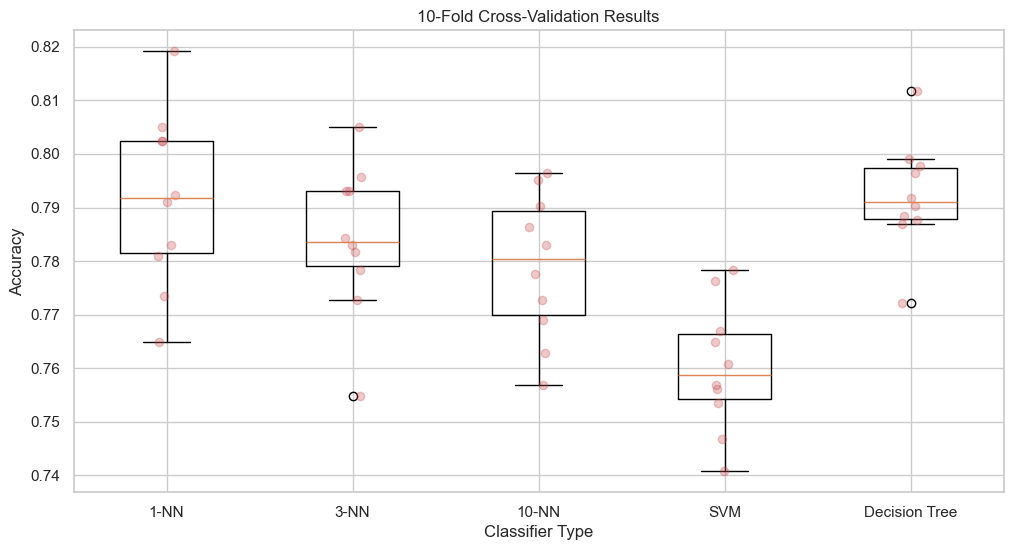

In [29]:
from sklearn import model_selection
from sklearn import neighbors, tree, svm, metrics

# Initialize an array to hold the accuracy scores for each fold and model
acc = np.zeros((10,5))

# Create a KFold object for 10-fold cross-validation
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=0) # random_state=0
# Get the number of splits (this line can be omitted as we don't use its result directly)
kf.get_n_splits()

# Loop counter
i = 0
# Iterate over each fold defined by KFold
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets based on the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize classifiers
    nn1 = neighbors.KNeighborsClassifier(n_neighbors=1)  # 1-nearest neighbor
    nn3 = neighbors.KNeighborsClassifier(n_neighbors=3)  # 3-nearest neighbors
    nn10 = neighbors.KNeighborsClassifier(n_neighbors=10)  # 3-nearest neighbors
    svc = svm.SVC()  # Support vector machine
    dt = tree.DecisionTreeClassifier()  # Decision tree
    
    # Train each classifier on the training set
    nn1.fit(X_train, y_train)
    nn3.fit(X_train, y_train)
    nn10.fit(X_train, y_train)
    svc.fit(X_train, y_train)
    dt.fit(X_train, y_train)
    
    # Make predictions on the testing set
    yhat_nn1 = nn1.predict(X_test)
    yhat_nn3 = nn3.predict(X_test)
    yhat_nn10 = nn10.predict(X_test)
    yhat_svc = svc.predict(X_test)
    yhat_dt = dt.predict(X_test)
    
    # Calculate and store the accuracy for each classifier
    acc[i][0] = metrics.accuracy_score(yhat_nn1, y_test)
    acc[i][1] = metrics.accuracy_score(yhat_nn3, y_test)
    acc[i][2] = metrics.accuracy_score(yhat_nn10, y_test)
    acc[i][3] = metrics.accuracy_score(yhat_svc, y_test)
    acc[i][4] = metrics.accuracy_score(yhat_dt, y_test)
    # Increment the loop counter
    i += 1

# Plotting the accuracy scores as a boxplot for each classifier
plt.boxplot(acc)
# Overlay individual accuracy scores as red dots for better visualization
for i in range(5):
    xderiv = (i+1)*np.ones(acc[:,i].shape) + (np.random.rand(10,) - 0.5) * 0.1
    plt.plot(xderiv, acc[:,i], 'ro', alpha=0.3)

# Setting the labels for each classifier on the x-axis
ax = plt.gca()
ax.set_xticklabels(['1-NN', '3-NN', '10-NN', 'SVM', 'Decision Tree'])

plt.xlabel('Classifier Type')
plt.ylabel('Accuracy')
plt.title('10-Fold Cross-Validation Results')

plt.show()   

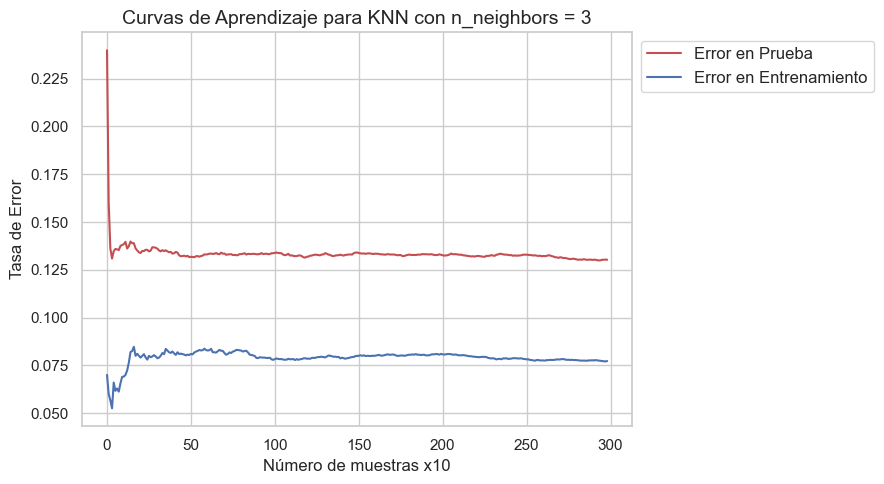

In [30]:
# ===== KNN ==========================================
# Establecer la complejidad del árbol de decisión en 5 (profundidad máxima de 5).
# C = 5  # Profundidad máxima del árbol de decisión (establecido en 5).
MAXN = 1000  # Número máximo de muestras por clase.
# Inicializar matrices para almacenar las tasas de error para 10 iteraciones y diferentes números de muestras de entrenamiento.
yhat_test_c5 = np.zeros((10, 299, 2))  # Error en prueba (tamaño: [iteraciones, tamaños de muestra, conjunto])
yhat_train_c5 = np.zeros((10, 299, 2))  # Error en entrenamiento
# Ejecutar el experimento 10 veces para obtener curvas suavizadas promedio.
for iteration in range(10):
    # Generar datos sintéticos para el conjunto de entrenamiento.
    # Usar distribuciones normales para crear datos representativos.
    X_train = np.concatenate([
        1.25 * np.random.randn(MAXN, 2),  # Primera distribución
        5 + 1.5 * np.random.randn(MAXN, 2),  # Segunda distribución
        [8, 5] + 1.5 * np.random.randn(MAXN, 2)  # Tercera distribución
    ])
    y_train = np.concatenate([
        np.ones((MAXN, 1)),  # Etiquetas para la primera clase
        -np.ones((MAXN, 1)),  # Etiquetas para la segunda clase
        np.ones((MAXN, 1))  # Etiquetas para la tercera clase
    ])
    # Aleatorizar los datos para asegurar la variabilidad.
    perm = np.random.permutation(y_train.size)
    X_train = X_train[perm, :]
    y_train = y_train[perm]
    # Generar datos sintéticos para el conjunto de prueba.
    X_test = np.concatenate([
        1.25 * np.random.randn(MAXN, 2), 
        5 + 1.5 * np.random.randn(MAXN, 2), 
        [8, 5] + 1.5 * np.random.randn(MAXN, 2)
    ])
    y_test = np.concatenate([
        np.ones((MAXN, 1)), 
        -np.ones((MAXN, 1)), 
        np.ones((MAXN, 1))
    ])
    # Evaluar el modelo con diferentes tamaños de muestra.
    for j, N in enumerate(range(10, 3000, 10)):
        # Tomar un subconjunto de datos para entrenamiento con los primeros N ejemplos.
        X_subset = X_train[:N, :]
        y_subset = y_train[:N]

        # Crear y entrenar un clasificador de árbol de decisión con una profundidad máxima de C (ahora 5).
        # clf = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=C)
        # clf.fit(X_subset, y_subset.ravel())  # Ajustar el modelo a los datos de entrenamiento.
        nn3 = neighbors.KNeighborsClassifier(n_neighbors=3)  # 3-nearest neighbors
        nn3.fit(X_subset, y_subset.ravel())       
                
        # Evaluar el modelo en el conjunto de prueba y calcular la tasa de error.
        yhat_test_c5[iteration, j, 1] = 1 - metrics.accuracy_score(nn3.predict(X_test), y_test.ravel())
        # Evaluar el modelo en el conjunto de entrenamiento y calcular la tasa de error.
        yhat_train_c5[iteration, j, 1] = 1 - metrics.accuracy_score(nn3.predict(X_subset), y_subset.ravel())
# Promediar las tasas de error a lo largo de las iteraciones para obtener una curva de aprendizaje más estable.
mean_test_error_c5 = np.mean(yhat_test_c5[:, :, 1].T, axis=1)
mean_train_error_c5 = np.mean(yhat_train_c5[:, :, 1].T, axis=1)
# Graficar las curvas de aprendizaje: tasa de error en prueba y entrenamiento.
plt.figure(figsize=(9, 5))
plt.plot(mean_test_error_c5, 'r', label='Error en Prueba')  # Error en el conjunto de prueba.
plt.plot(mean_train_error_c5, 'b', label='Error en Entrenamiento')  # Error en el conjunto de entrenamiento.
# Configurar etiquetas, título y leyenda.
plt.xlabel('Número de muestras x10', fontsize=12)
plt.ylabel('Tasa de Error', fontsize=12)
plt.title('Curvas de Aprendizaje para KNN con n_neighbors = 3', fontsize=14)
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))  
# Mostrar la gráfica con las curvas de error.
plt.grid(True)
plt.tight_layout()  # Ajustar la distribución para evitar que las etiquetas se corten.
plt.show()

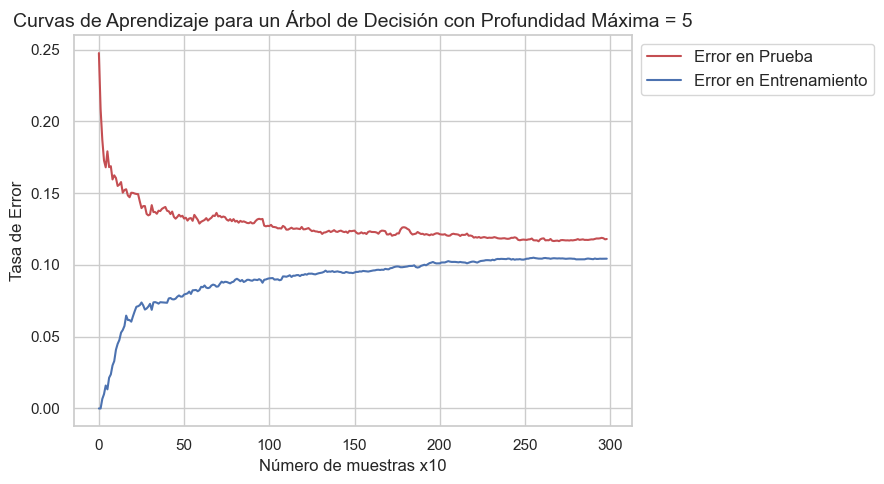

In [31]:
# ===== Decision Tree ==========================================
# Establecer la complejidad del árbol de decisión en 5 (profundidad máxima de 5).
C = 5  # Profundidad máxima del árbol de decisión (establecido en 5).
MAXN = 1000  # Número máximo de muestras por clase.
# Inicializar matrices para almacenar las tasas de error para 10 iteraciones y diferentes números de muestras de entrenamiento.
yhat_test_c5 = np.zeros((10, 299, 2))  # Error en prueba (tamaño: [iteraciones, tamaños de muestra, conjunto])
yhat_train_c5 = np.zeros((10, 299, 2))  # Error en entrenamiento
# Ejecutar el experimento 10 veces para obtener curvas suavizadas promedio.
for iteration in range(10):
    # Generar datos sintéticos para el conjunto de entrenamiento.
    # Usar distribuciones normales para crear datos representativos.
    X_train = np.concatenate([
        1.25 * np.random.randn(MAXN, 2),  # Primera distribución
        5 + 1.5 * np.random.randn(MAXN, 2),  # Segunda distribución
        [8, 5] + 1.5 * np.random.randn(MAXN, 2)  # Tercera distribución
    ])
    y_train = np.concatenate([
        np.ones((MAXN, 1)),  # Etiquetas para la primera clase
        -np.ones((MAXN, 1)),  # Etiquetas para la segunda clase
        np.ones((MAXN, 1))  # Etiquetas para la tercera clase
    ])
    # Aleatorizar los datos para asegurar la variabilidad.
    perm = np.random.permutation(y_train.size)
    X_train = X_train[perm, :]
    y_train = y_train[perm]
    # Generar datos sintéticos para el conjunto de prueba.
    X_test = np.concatenate([
        1.25 * np.random.randn(MAXN, 2), 
        5 + 1.5 * np.random.randn(MAXN, 2), 
        [8, 5] + 1.5 * np.random.randn(MAXN, 2)
    ])
    y_test = np.concatenate([
        np.ones((MAXN, 1)), 
        -np.ones((MAXN, 1)), 
        np.ones((MAXN, 1))
    ])
    # Evaluar el modelo con diferentes tamaños de muestra.
    for j, N in enumerate(range(10, 3000, 10)):
        # Tomar un subconjunto de datos para entrenamiento con los primeros N ejemplos.
        X_subset = X_train[:N, :]
        y_subset = y_train[:N]
        # Crear y entrenar un clasificador de árbol de decisión con una profundidad máxima de C (ahora 5).
        clf = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=C)
        clf.fit(X_subset, y_subset.ravel())  # Ajustar el modelo a los datos de entrenamiento.
        # Evaluar el modelo en el conjunto de prueba y calcular la tasa de error.
        yhat_test_c5[iteration, j, 1] = 1 - metrics.accuracy_score(clf.predict(X_test), y_test.ravel())
        # Evaluar el modelo en el conjunto de entrenamiento y calcular la tasa de error.
        yhat_train_c5[iteration, j, 1] = 1 - metrics.accuracy_score(clf.predict(X_subset), y_subset.ravel())
# Promediar las tasas de error a lo largo de las iteraciones para obtener una curva de aprendizaje más estable.
mean_test_error_c5 = np.mean(yhat_test_c5[:, :, 1].T, axis=1)
mean_train_error_c5 = np.mean(yhat_train_c5[:, :, 1].T, axis=1)
# Graficar las curvas de aprendizaje: tasa de error en prueba y entrenamiento.
plt.figure(figsize=(9, 5))
plt.plot(mean_test_error_c5, 'r', label='Error en Prueba')  # Error en el conjunto de prueba.
plt.plot(mean_train_error_c5, 'b', label='Error en Entrenamiento')  # Error en el conjunto de entrenamiento.
# Configurar etiquetas, título y leyenda.
plt.xlabel('Número de muestras x10', fontsize=12)
plt.ylabel('Tasa de Error', fontsize=12)
plt.title('Curvas de Aprendizaje para un Árbol de Decisión con Profundidad Máxima = 5', fontsize=14)
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))  
# Mostrar la gráfica con las curvas de error.
plt.grid(True)
plt.tight_layout()  # Ajustar la distribución para evitar que las etiquetas se corten.
plt.show()